In [74]:
import pandas as pd

In [75]:
import numpy as np
import math

In [76]:
from sklearn.preprocessing import MinMaxScaler

In [77]:
from sklearn.decomposition import PCA

In [78]:
import matplotlib.pyplot as plt
%matplotlib inline

In [79]:
data = pd.read_csv('final_data.csv')

In [80]:
data = data.set_index('country')

In [81]:
def pca_algo(good_data, pca):
    '''
    Create a DataFrame of the PCA results
    Includes dimension feature weights and explained variance
    Visualizes the PCA results
    '''
    # Dimension indexing
    dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]
    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = good_data.keys())
    components.index = dimensions
    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions
    # Create a bar plot visualization
    fig, ax = plt.subplots(figsize = (14,8))
    # Plot the feature weights as a function of the components
    components.plot(ax = ax, kind = 'bar');
    ax.set_ylabel("Feature Weights")
    ax.set_xticklabels(dimensions, rotation=0)
    # Display the explained variance ratios
    for i, ev in enumerate(pca.explained_variance_ratio_):
        ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n %.4f"%(ev))
    # Return a concatenated DataFrame
    return pd.concat([variance_ratios, components], axis = 1)

def cluster_results(reduced_data, preds, centers, pca_samples):
    '''
    Visualizes the PCA-reduced cluster data in two dimensions
    Adds cues for cluster centers and student-selected sample data
    '''
    predictions = pd.DataFrame(preds, columns = ['Cluster'])
    plot_data = pd.concat([predictions, reduced_data], axis = 1)
    # Generate the cluster plot
    fig, ax = plt.subplots(figsize = (14,8))
    # Color map
    cmap = cm.get_cmap('gist_rainbow')
    # Color the points based on assigned cluster
    for i, cluster in plot_data.groupby('Cluster'):   
        cluster.plot(ax = ax, kind = 'scatter', x = 'Dimension 1', y = 'Dimension 2', \
                     color = cmap((i)*1.0/(len(centers)-1)), label = 'Cluster %i'%(i), s=30);
    # Plot centers with indicators
    for i, c in enumerate(centers):
        ax.scatter(x = c[0], y = c[1], color = 'white', edgecolors = 'black', \
                   alpha = 1, linewidth = 2, marker = 'o', s=200);
        ax.scatter(x = c[0], y = c[1], marker='$%d$'%(i), alpha = 1, s=100);
    # Plot transformed sample points 
    ax.scatter(x = pca_samples[:,0], y = pca_samples[:,1], \
               s = 150, linewidth = 4, color = 'black', marker = 'x');
    # Set plot title
    ax.set_title("Cluster Learning on PCA-Reduced Data - Centroids Marked by Number\nTransformed Sample Data Marked by Black Cross");


def channel_results(reduced_data, outliers, pca_samples):
    '''
    Visualizes the PCA-reduced cluster data in two dimensions using the full dataset
    Data is labeled by "Channel" and cues added for student-selected sample data
    '''
    # Check that the dataset is loadable
    try:
        full_data = pd.read_csv("customers.csv")
    except:
        print "Dataset could not be loaded. Is the file missing?"
        return False
    # Create the Channel DataFrame
    channel = pd.DataFrame(full_data['Channel'], columns = ['Channel'])
    channel = channel.drop(channel.index[outliers]).reset_index(drop = True)
    labeled = pd.concat([reduced_data, channel], axis = 1)
    
    # Generate the cluster plot
    fig, ax = plt.subplots(figsize = (14,8))
    # Color map
    cmap = cm.get_cmap('gist_rainbow')
    # Color the points based on assigned Channel
    labels = ['Hotel/Restaurant/Cafe', 'Retailer']
    grouped = labeled.groupby('Channel')
    for i, channel in grouped:   
        channel.plot(ax = ax, kind = 'scatter', x = 'Dimension 1', y = 'Dimension 2', \
                     color = cmap((i-1)*1.0/2), label = labels[i-1], s=30);
        
    # Plot transformed sample points   
    for i, sample in enumerate(pca_samples):
        ax.scatter(x = sample[0], y = sample[1], \
               s = 200, linewidth = 3, color = 'black', marker = 'o', facecolors = 'none');
        ax.scatter(x = sample[0]+0.25, y = sample[1]+0.3, marker='$%d$'%(i), alpha = 1, s=125);
    # Set plot title
    ax.set_title("PCA-Reduced Data Labeled by 'Channel'\nTransformed Sample Data Circled");
    #plt.savefig('CustomerSegmentsClustering.png', dpi=400)

In [82]:
index_ = data.index

In [83]:
cols = data.columns

In [84]:
min_max_scaling = False
if min_max_scaling:
    scaler = MinMaxScaler()
    xdata = scaler.fit_transform(data)
else:
    xdata = data[:]

In [85]:
xdata = pd.DataFrame(xdata)
xdata.columns = cols

In [86]:
xdata['country'] = index_

In [87]:
xdata = xdata.set_index('country')

In [88]:
def znorm(data):
    for i in data.columns:
        data[i] = data[i].astype(float)
        data[i] = (data[i] - data[i].mean())/ data[i].std()

In [89]:
z_normalized = True
if z_normalized:
    znorm(xdata)

Dimension 1     0.3304
Dimension 2     0.5585
Dimension 3     0.6552
Dimension 4     0.7406
Dimension 5     0.8053
Dimension 6     0.8589
Dimension 7     0.9070
Dimension 8     0.9337
Dimension 9     0.9586
Dimension 10    0.9792
Dimension 11    0.9891
Dimension 12    0.9930
Dimension 13    0.9960
Dimension 14    0.9977
Dimension 15    0.9987
Dimension 16    0.9995
Dimension 17    0.9999
Name: Explained Variance, dtype: float64


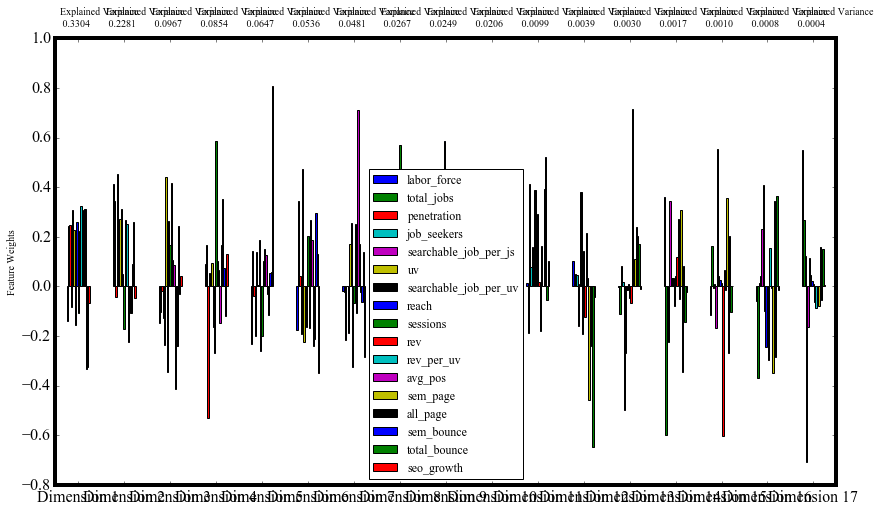

In [90]:
#pca = PCA(n_components=len(xdata.keys()))
pca = PCA(n_components=17)
pca.fit(xdata)
# Transform the sample log-data using the PCA fit above
pca_samples = pca.transform(xdata)

# Generate PCA results plot
pca_results = pca_algo(xdata, pca)
print pca_results['Explained Variance'].cumsum()

In [91]:
#reduce to two dimensions 
pca = PCA(n_components=2)
pca.fit(xdata)
reduced_data = pca.transform(xdata)

In [92]:
small = pca.transform(xdata.loc[['US',  'JP', 'UK', 'AU', 'DE', 'IN', 'ID', 'PH', 'SG'], :])

In [93]:
small

array([[  7.75933489e+00,   7.19533318e+00],
       [  8.81798640e+00,   4.33842030e+00],
       [  4.29173207e+00,   9.17558298e-01],
       [  4.97739378e-01,  -4.60644604e-02],
       [  1.26250628e+00,   1.82551897e-01],
       [ -3.46927168e+00,   3.45757580e+00],
       [ -1.86930089e+00,  -2.63020078e-03],
       [ -8.95336098e-01,  -5.85421633e-01],
       [  6.43095688e-02,  -3.49443088e-01]])

In [94]:
def unzipper(zipped, as_list=True):
    if not zipped:
        return [], []
    if not as_list:
        return zip(*zipped)
    else:
        a, b =zip(*zipped)
        return list(a), list(b)

In [95]:
x, y = unzipper(list(reduced_data))

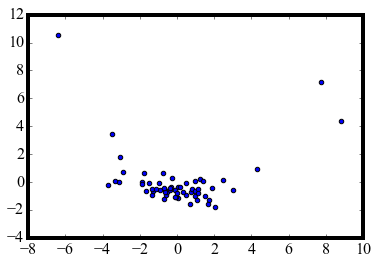

In [96]:
plt.scatter(x, y)

In [97]:
# TODO: Apply your clustering algorithm of choice to the reduced data 
from sklearn.mixture import GaussianMixture
for n in range(2, 11):
    clusterer = GaussianMixture(n_components = n, random_state=143)
    clusterer.fit(reduced_data)
    # Predict the cluster for each data point
    preds = clusterer.predict(reduced_data)
    
    # Find the cluster centers
    centers = clusterer.means_
    
    # Predict the cluster for each transformed sample data point
    sample_preds = clusterer.predict(small)
    
    # Calculate the mean silhouette coefficient for the number of clusters chosen
    from sklearn.metrics import silhouette_score
    score = silhouette_score(reduced_data, preds)
    print "For {} clusters we get a silhouette coefficient of {:0.3f}".format(n, score)

For 2 clusters we get a silhouette coefficient of 0.771
For 3 clusters we get a silhouette coefficient of 0.769
For 4 clusters we get a silhouette coefficient of 0.284
For 5 clusters we get a silhouette coefficient of 0.373
For 6 clusters we get a silhouette coefficient of 0.353
For 7 clusters we get a silhouette coefficient of 0.330
For 8 clusters we get a silhouette coefficient of 0.364
For 9 clusters we get a silhouette coefficient of 0.322
For 10 clusters we get a silhouette coefficient of 0.347


In [98]:
def plot_results(X, Y_, means, covariances, index, title):
    splot = plt.subplot(2, 1, 1 + index)
    for i, (mean, covar, color) in enumerate(zip(
            means, covariances, color_iter)):
        v, w = linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], 10.0, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)

    #plt.xlim(-9., 5.)
    #plt.ylim(-3., 6.)
    #plt.xticks(())
    #plt.yticks(())
    plt.title(title)

In [99]:

# Apply your clustering algorithm of choice to the reduced data 
from sklearn.mixture import GaussianMixture as GMM
clusterer = GMM(n_components = 4, random_state=143)
clusterer.fit(reduced_data)
# Predict the cluster for each data point
preds = clusterer.predict(reduced_data)

# Find the cluster centers
centers = clusterer.means_

# Predict the cluster for each transformed sample data point
sample_preds = clusterer.predict(small)


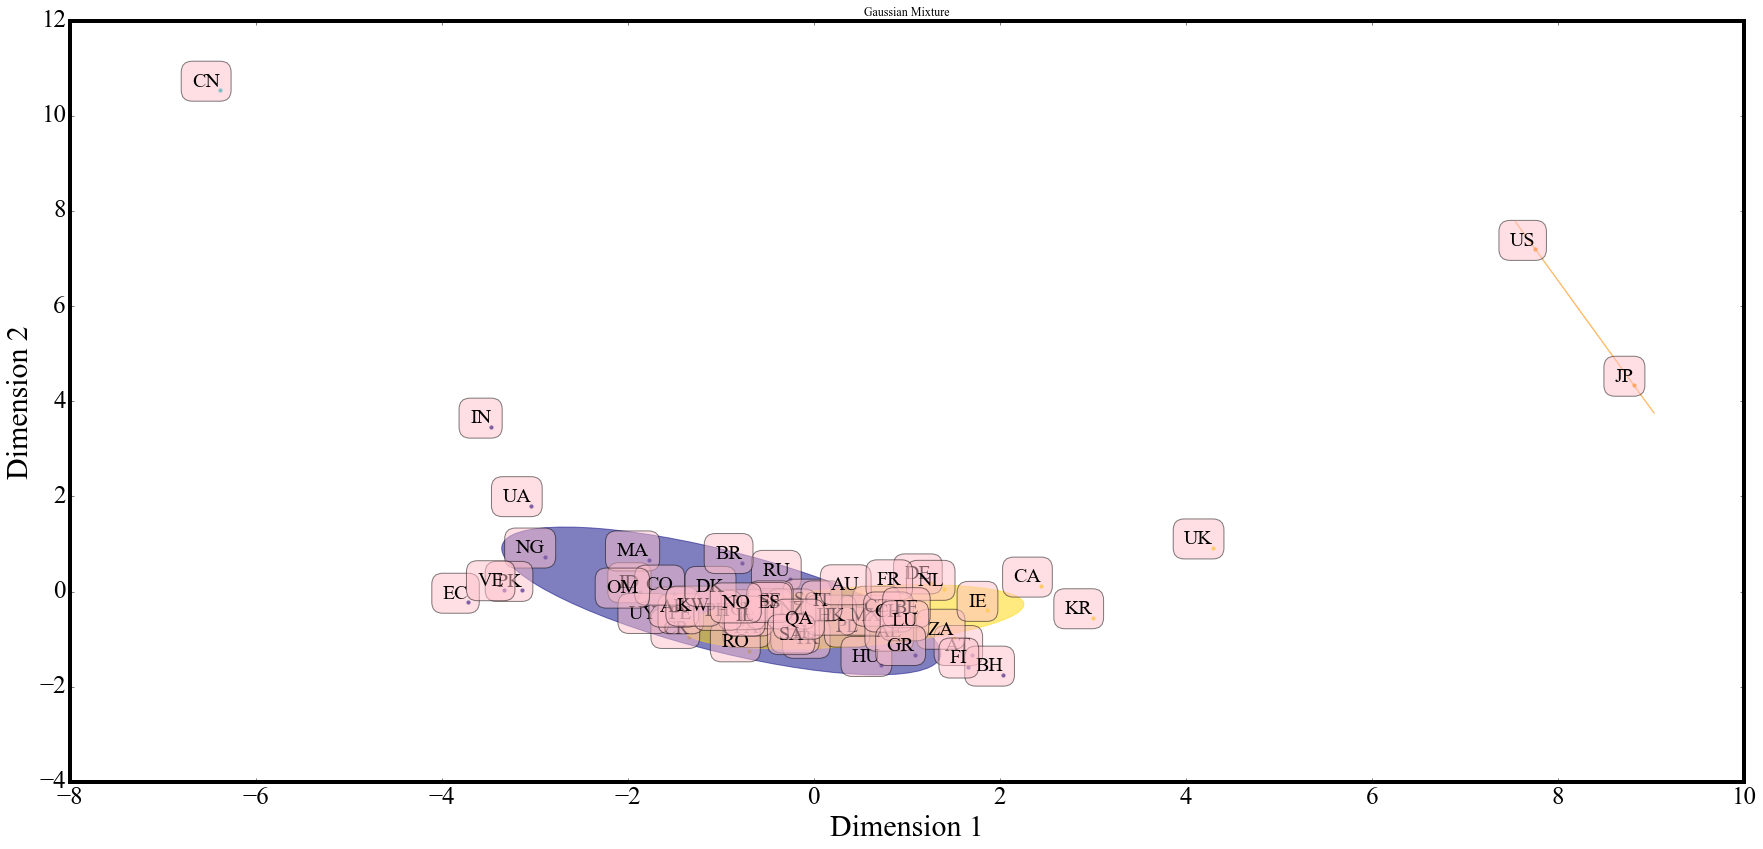

In [100]:
%matplotlib inline
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as grd
import matplotlib.ticker as tkr
import matplotlib.font_manager as font_manager

from matplotlib.ticker import AutoMinorLocator
from matplotlib.ticker import FuncFormatter
from matplotlib import rcParams

#define plotter
minorLocatorx   = AutoMinorLocator(10)
minorLocatory   = AutoMinorLocator(4)
matplotlib.rc('xtick', labelsize=16) 
matplotlib.rc('ytick', labelsize=16) 
matplotlib.rcParams['axes.linewidth'] = 2.
plt.rcParams['axes.linewidth'] = 4
plt.rc('font', family='serif')
plt.rc('font', serif='Times New Roman') 
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 30
fig_size[1] = 30
plt.rcParams["figure.figsize"] = fig_size

import itertools
from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl
color_iter = itertools.cycle(['navy', 'c', 'darkorange', 'gold',
                              'darkorange'])
plot_results(reduced_data, preds, clusterer.means_, clusterer.covariances_, 0,
             'Gaussian Mixture')
plt.xlabel('Dimension 1', fontsize=30)
plt.ylabel('Dimension 2', fontsize=30)
test = pd.DataFrame(reduced_data, columns=['Dimension1', 'Dimension2'])
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
test['country'] = xdata.reset_index()['country']

for label, x, y in zip(test['country'], test['Dimension1'], test['Dimension2']):
    plt.annotate(
        label, 
        xy = (x, y), xytext = (0, 0), fontsize=20,
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.55', fc = 'pink', alpha = 0.5))